In [ ]:
import os
import marimo as mo
import cyvcf2
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def read_sample_sex():
    """Read sample sex information from file."""
    sex_path = "xhetrel/sample_sex"
    sex_df = pd.read_csv(sex_path, sep='\t', names=['Sample', 'Sex'])

    # Translate Turkish sex labels to English
    sex_translation = {
        'Kadın': 'female',
        'Erkek': 'male'
    }
    sex_df['Sex'] = sex_df['Sex'].map(sex_translation)

    # Remove samples with missing sex information
    sex_df = sex_df.dropna(subset=['Sex'])

    return sex_df


In [ ]:
def read_vcf_variants():
    """Read VCF file and extract all variant information."""
    vcf_path = "xhetrel/chrX.vcf.gz"
    reader = cyvcf2.Reader(vcf_path)

    variants_data = []

    for variant in reader:
        for i, sample in enumerate(reader.samples):
            # Get DP and VAF
            dp = variant.format('DP')[i][0]
            vaf_values = variant.format('VAF')

            # Skip if VAF is not available or NaN
            if vaf_values is None or np.isnan(vaf_values[i][0]):
                continue

            vaf = vaf_values[i][0]
            gt_type = variant.gt_types[i]

            # Skip UNKNOWN genotypes (gt_type == 2)
            if gt_type == 2:
                continue

            # Store variant data
            variants_data.append({
                'sample': sample,
                'dp': dp,
                'vaf': vaf,
                'gt_type': gt_type,
                'is_het': gt_type == 1,  # HET
                'is_hom_alt': gt_type == 3  # HOM_ALT
            })

    return pd.DataFrame(variants_data)


In [ ]:
def apply_filters(variants_df, min_dp=0, min_vaf=0):
    """Apply DP and VAF filters to variants."""
    filtered_df = variants_df[
        (variants_df['dp'] > min_dp) & 
        (variants_df['vaf'] > min_vaf)
    ].copy()

    return filtered_df

In [ ]:
def subset_variants(variants_df, percentage, random_seed=42):
    """Randomly subset variants for each sample."""
    if percentage >= 1.0:
        return variants_df

    np.random.seed(random_seed)
    subsetted_data = []

    for sample in variants_df['sample'].unique():
        sample_variants = variants_df[variants_df['sample'] == sample]
        n_variants = len(sample_variants)
        n_subset = max(1, int(n_variants * percentage))

        # Randomly sample variants
        subset_indices = np.random.choice(n_variants, size=n_subset, replace=False)
        subsetted_variants = sample_variants.iloc[subset_indices]
        subsetted_data.append(subsetted_variants)

    return pd.concat(subsetted_data, ignore_index=True)


In [ ]:
def calculate_heterozygosity_ratios(variants_df):
    """Calculate heterozygosity ratios for each sample."""
    sample_stats = []

    for sample in variants_df['sample'].unique():
        sample_variants = variants_df[variants_df['sample'] == sample]

        het_count = sample_variants['is_het'].sum()
        hom_alt_count = sample_variants['is_hom_alt'].sum()
        total_variants = len(sample_variants)
        total_het_hom = het_count + hom_alt_count

        if total_het_hom > 0:
            het_ratio = het_count / total_het_hom
            sample_stats.append({
                'Sample': sample,
                'Heterozygous_Ratio': het_ratio,
                'Total_Variants': total_variants,
                'Het_Variants': het_count,
                'Hom_Alt_Variants': hom_alt_count,
                'Het_Hom_Total': total_het_hom
            })

    return pd.DataFrame(sample_stats)


In [ ]:
def perform_statistical_analysis(het_ratios_df):
    """Perform statistical tests comparing heterozygosity ratios between sexes."""
    female_ratios = het_ratios_df[het_ratios_df['Sex'] == 'female']['Heterozygous_Ratio']
    male_ratios = het_ratios_df[het_ratios_df['Sex'] == 'male']['Heterozygous_Ratio']

    # Mann-Whitney U test
    mw_stat, mw_pval = stats.mannwhitneyu(female_ratios, male_ratios, alternative='two-sided')

    # T-test
    t_stat, t_pval = stats.ttest_ind(female_ratios, male_ratios)

    # Effect size (Cohen's d)
    cohens_d = (female_ratios.mean() - male_ratios.mean()) / np.sqrt((female_ratios.var() + male_ratios.var()) / 2)

    return {
        'mw_pval': mw_pval,
        't_pval': t_pval,
        'cohens_d': cohens_d,
        'female_mean': female_ratios.mean(),
        'male_mean': male_ratios.mean(),
        'female_std': female_ratios.std(),
        'male_std': male_ratios.std()
    }


In [ ]:
def calculate_confidence_intervals_scipy(data, confidence=0.95):
    """Calculate confidence intervals for the mean using scipy.stats.bootstrap."""
    # The data must be in a specific shape (n_samples, n_features)
    # For a 1D array, we reshape it.
    data = (data,)

    # Calculate bootstrap confidence interval for the mean
    res = stats.bootstrap(data, np.mean, confidence_level=confidence, method='percentile')

    return res.confidence_interval


In [ ]:
def perform_classification_analysis(het_ratios_df):
    """Perform logistic regression to classify sex based on heterozygosity ratio."""
    # Prepare data - keep Sex for filtering later
    X = het_ratios_df[['Heterozygous_Ratio', 'Sex']] # Temporarily keep Sex in X
    y = (het_ratios_df['Sex'] == 'female').astype(int)

    # Cross-validation (on full X without Sex for model fitting)
    model = LogisticRegression()
    cv_scores = cross_val_score(model, X[['Heterozygous_Ratio']], y, cv=5)

    # Train-test split, keeping Sex in X_test for filtering
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit model (only on Heterozygous_Ratio)
    model.fit(X_train[['Heterozygous_Ratio']], y_train)

    # Predictions
    y_pred = model.predict(X_test[['Heterozygous_Ratio']])
    y_pred_proba = model.predict_proba(X_test[['Heterozygous_Ratio']])[:, 1]

    # Calculate thresholds for each sex
    female_ratios = het_ratios_df[het_ratios_df['Sex'] == 'female']['Heterozygous_Ratio']
    male_ratios = het_ratios_df[het_ratios_df['Sex'] == 'male']['Heterozygous_Ratio']

    # Calculate mean and standard deviation for each sex
    female_mean = female_ratios.mean()
    female_std = female_ratios.std()
    male_mean = male_ratios.mean()
    male_std = male_ratios.std()

    # Calculate confidence intervals using scipy
    female_mean_ci = calculate_confidence_intervals_scipy(female_ratios.to_numpy())
    male_mean_ci = calculate_confidence_intervals_scipy(male_ratios.to_numpy())

    # Calculate thresholds as mean ± 1 standard deviation
    female_threshold = female_mean - female_std
    male_threshold = male_mean + male_std
    midpoint_threshold = (male_threshold + female_threshold) / 2

    # Calculate threshold confidence intervals
    female_threshold_ci = [
        female_mean_ci.low - female_std,  # Lower bound
        female_mean_ci.high - female_std # Upper bound
    ]
    male_threshold_ci = [
        male_mean_ci.low + male_std,      # Lower bound
        male_mean_ci.high + male_std       # Upper bound
    ]

    # Calculate optimal threshold using ROC curve (overall)
    fpr_overall, tpr_overall, thresholds_overall = roc_curve(y_test, y_pred_proba)

    # Sex-specific Youden's J and CI
    female_test_mask = (X_test['Sex'] == 'female')
    male_test_mask = (X_test['Sex'] == 'male')

    female_y_test = y_test[female_test_mask]
    female_y_pred_proba = y_pred_proba[female_test_mask]

    male_y_test = y_test[male_test_mask]
    male_y_pred_proba = y_pred_proba[male_test_mask]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    return {
        'accuracy': accuracy,
        'auc': auc,
        'female_threshold': female_threshold,
        'male_threshold': male_threshold,
        'female_threshold_ci': female_threshold_ci,
        'male_threshold_ci': male_threshold_ci,
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'model': model,
        'X_test': X_test[['Heterozygous_Ratio']], # Return X_test without Sex
        'y_test': y_test,
        'y_pred_proba': y_pred_proba,
        'female_mean': female_mean,
        'female_std': female_std,
        'male_mean': male_mean,
        'male_std': male_std,
        'female_mean_ci': [female_mean_ci.low, female_mean_ci.high],
        'male_mean_ci': [male_mean_ci.low, male_mean_ci.high],
        'midpoint_threshold': midpoint_threshold
    }


In [ ]:
def analyze_condition(variants_df, sex_df, condition_name, min_dp=0, min_vaf=0, percentage=1.0):
    """Analyze a single condition (DP/VAF filter + variant percentage)."""
    print(f"\nAnalyzing: {condition_name}")
    print("-" * 50)

    # Apply filters
    filtered_variants = apply_filters(variants_df, min_dp=min_dp, min_vaf=min_vaf)
    print(f"Variants after DP>{min_dp} and VAF>{min_vaf} filter: {len(filtered_variants)}")

    # Subset variants
    subset_variants_df = subset_variants(filtered_variants, percentage)
    print(f"Variants after {percentage*100}% subsetting: {len(subset_variants_df)}")

    # Calculate heterozygosity ratios
    het_ratios_df = calculate_heterozygosity_ratios(subset_variants_df)

    # Merge with sex information
    het_ratios_df = het_ratios_df.merge(sex_df, on='Sample', how='inner')
    het_ratios_df = het_ratios_df.sort_values('Heterozygous_Ratio', ascending=False)

    print(f"Samples with data: {len(het_ratios_df)}")
    print(f"Females: {len(het_ratios_df[het_ratios_df['Sex'] == 'female'])}")
    print(f"Males: {len(het_ratios_df[het_ratios_df['Sex'] == 'male'])}")

    # Statistical analysis
    stats_results = perform_statistical_analysis(het_ratios_df)
    print(f"\nStatistical Results:")
    print(f"Female mean \u00b1 std: {stats_results['female_mean']:.3f} \u00b1 {stats_results['female_std']:.3f}")
    print(f"Male mean \u00b1 std: {stats_results['male_mean']:.3f} \u00b1 {stats_results['male_std']:.3f}")
    print(f"Mann-Whitney p-value: {stats_results['mw_pval']:.2e}")
    print(f"T-test p-value: {stats_results['t_pval']:.2e}")
    print(f"Cohen's d: {stats_results['cohens_d']:.3f}")

    # Classification analysis
    classification_results = perform_classification_analysis(het_ratios_df)
    print(f"\nClassification Results:")
    print(f"Accuracy: {classification_results['accuracy']:.3f}")
    print(f"AUC-ROC: {classification_results['auc']:.3f}")
    print(f"CV Mean \u00b1 Std: {classification_results['cv_mean']:.3f} \u00b1 {classification_results['cv_std']:.3f}")


    return {
        'condition_name': condition_name,
        'het_ratios_df': het_ratios_df,
        'stats_results': stats_results,
        'classification_results': classification_results,
        'n_variants_filtered': len(filtered_variants),
        'n_variants_subset': len(subset_variants_df),
        'n_samples': len(het_ratios_df)
    }


In [ ]:
def run_full_analysis():
    """Run the complete analysis for all conditions."""
    # Load data
    print("Loading data...")
    variants_df = read_vcf_variants()
    sex_df = read_sample_sex()

    print(f"Total variants loaded: {len(variants_df)}")
    print(f"Unique samples: {variants_df['sample'].nunique()}")
    print(f"Sex information for {len(sex_df)} samples")

    # Define conditions
    dp_filters = [0, 10, 20]  # DP > 0, DP > 10, DP > 20
    vaf_filters = [0, 0.25]  # VAF > 0, VAF > 0.25
    percentages = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 1.0]  # 1%, 5%, 10%, 25%, 50%, 75%, 100%

    results = {}

    # Run analysis for each combination
    for dp in dp_filters:
        for vaf in vaf_filters:
            condition_base = f"DP>{dp}_VAF>{vaf}"

            for pct in percentages:
                condition_name = f"{condition_base}_{int(pct*100)}pct"

                result = analyze_condition(
                    variants_df, sex_df, condition_name, 
                    min_dp=dp, min_vaf=vaf, percentage=pct
                )

                results[condition_name] = result

    return results, variants_df, sex_df


In [ ]:
def create_summary_table(results):
    """Create a summary table of all results."""
    summary_data = []

    for condition_name, result in results.items():
        stats_res = result['stats_results']
        classification = result['classification_results']
        het_ratios_df = result['het_ratios_df'] # Access het_ratios_df for current condition

        # Handle potential NaN if no males or females in subset or if max/min is NaN

        summary_data.append({
            'Condition': condition_name,
            'N_Samples': result['n_samples'],
            'N_Variants_Subset': result['n_variants_subset'],
            'Female_Mean_Het_Ratio': f"{stats_res['female_mean']:.2f}",
            'Male_Mean_Het_Ratio': f"{stats_res['male_mean']:.2f}",
            'Cohens_D': f"{stats_res['cohens_d']:.3f}",
            'MW_pvalue': f"{stats_res['mw_pval']:.2e}",
            'T_test_pvalue': f"{stats_res['t_pval']:.2e}",
            'Accuracy': f"{classification['accuracy']:.2f}",
            'AUC_ROC': f"{classification['auc']:.2f}",
            'CV_Mean': f"{classification['cv_mean']:.2f}",
            'Female_Threshold': f"{classification['female_threshold']:.2f}",
            'Male_Threshold': f"{classification['male_threshold']:.2f}",
            'Female_Threshold_CI': f"[{classification['female_threshold_ci'][0]:.2f}, {classification['female_threshold_ci'][1]:.2f}]",
            'Male_Threshold_CI': f"[{classification['male_threshold_ci'][0]:.3f}, {classification['male_threshold_ci'][1]:.3f}]",
            'Midpoint_Threshold': f"{classification['midpoint_threshold']:.2f}"
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df


In [ ]:
def save_results(results, output_dir="xhetrel"):
    """Save all results to files."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save individual heterozygosity ratio files
    for condition_name, result in results.items():
        het_ratios_df = result['het_ratios_df']
        output_file = os.path.join(output_dir, f"xhet_{condition_name}.tsv")
        het_ratios_df.to_csv(output_file, sep='\t', index=False)
        print(f"Saved: {output_file}")

    # Save summary table
    summary_df = create_summary_table(results)
    summary_file = os.path.join(output_dir, "analysis_summary.tsv")
    summary_df.to_csv(summary_file, sep='\t', index=False)
    print(f"Saved: {summary_file}")

    return summary_df


In [ ]:
# Run the analysis
print("Starting X heterozygosity analysis...")
results, variants_df, sex_df = run_full_analysis()

# Create and display summary
summary_df = create_summary_table(results)
print("\n" + "="*100)
print("ANALYSIS SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))

# Save results
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)
save_results(results)


Starting X heterozygosity analysis...
Loading data...


Total variants loaded: 269494
Unique samples: 163
Sex information for 142 samples

Analyzing: DP>0_VAF>0_1pct
--------------------------------------------------


Variants after DP>0 and VAF>0 filter: 269492


Variants after 1.0% subsetting: 2613


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.566 ± 0.104
Male mean ± std: 0.022 ± 0.040
Mann-Whitney p-value: 7.59e-25
T-test p-value: 4.70e-76
Cohen's d: 6.922



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0_5pct
--------------------------------------------------


Variants after DP>0 and VAF>0 filter: 269492


Variants after 5.0% subsetting: 13395


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.562 ± 0.052
Male mean ± std: 0.026 ± 0.019
Mann-Whitney p-value: 3.81e-24
T-test p-value: 2.82e-115
Cohen's d: 13.655



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0_10pct
--------------------------------------------------


Variants after DP>0 and VAF>0 filter: 269492


Variants after 10.0% subsetting: 26877


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.565 ± 0.041
Male mean ± std: 0.025 ± 0.014
Mann-Whitney p-value: 3.90e-24
T-test p-value: 1.61e-130
Cohen's d: 17.687



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0_25pct
--------------------------------------------------


Variants after DP>0 and VAF>0 filter: 269492


Variants after 25.0% subsetting: 67312


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.563 ± 0.031
Male mean ± std: 0.023 ± 0.009
Mann-Whitney p-value: 3.91e-24
T-test p-value: 6.16e-148
Cohen's d: 23.706



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0_50pct
--------------------------------------------------


Variants after DP>0 and VAF>0 filter: 269492


Variants after 50.0% subsetting: 134702


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.564 ± 0.026
Male mean ± std: 0.023 ± 0.006
Mann-Whitney p-value: 3.91e-24
T-test p-value: 1.92e-158
Cohen's d: 28.360



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0_75pct
--------------------------------------------------


Variants after DP>0 and VAF>0 filter: 269492


Variants after 75.0% subsetting: 202053


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.564 ± 0.026
Male mean ± std: 0.023 ± 0.005
Mann-Whitney p-value: 3.91e-24
T-test p-value: 2.33e-159
Cohen's d: 28.857



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0_100pct
--------------------------------------------------


Variants after DP>0 and VAF>0 filter: 269492
Variants after 100.0% subsetting: 269492


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.564 ± 0.026
Male mean ± std: 0.023 ± 0.004
Mann-Whitney p-value: 3.91e-24
T-test p-value: 7.40e-161
Cohen's d: 29.605



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0.25_1pct
--------------------------------------------------


Variants after DP>0 and VAF>0.25 filter: 268146


Variants after 1.0% subsetting: 2598


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.558 ± 0.118
Male mean ± std: 0.033 ± 0.060
Mann-Whitney p-value: 1.10e-24
T-test p-value: 2.44e-65
Cohen's d: 5.617



Classification Results:
Accuracy: 0.966
AUC-ROC: 1.000
CV Mean ± Std: 0.972 ± 0.034

Analyzing: DP>0_VAF>0.25_5pct
--------------------------------------------------


Variants after DP>0 and VAF>0.25 filter: 268146


Variants after 5.0% subsetting: 13330


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.559 ± 0.050
Male mean ± std: 0.024 ± 0.020
Mann-Whitney p-value: 3.70e-24
T-test p-value: 1.67e-117
Cohen's d: 14.137



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0.25_10pct
--------------------------------------------------


Variants after DP>0 and VAF>0.25 filter: 268146


Variants after 10.0% subsetting: 26741


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.563 ± 0.037
Male mean ± std: 0.022 ± 0.015
Mann-Whitney p-value: 3.90e-24
T-test p-value: 4.58e-136
Cohen's d: 19.291



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0.25_25pct
--------------------------------------------------


Variants after DP>0 and VAF>0.25 filter: 268146


Variants after 25.0% subsetting: 66971


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.560 ± 0.030
Male mean ± std: 0.023 ± 0.007
Mann-Whitney p-value: 3.91e-24
T-test p-value: 4.98e-150
Cohen's d: 24.627



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0.25_50pct
--------------------------------------------------


Variants after DP>0 and VAF>0.25 filter: 268146


Variants after 50.0% subsetting: 134030


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.560 ± 0.025
Male mean ± std: 0.023 ± 0.006
Mann-Whitney p-value: 3.91e-24
T-test p-value: 2.73e-160
Cohen's d: 29.231



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0.25_75pct
--------------------------------------------------


Variants after DP>0 and VAF>0.25 filter: 268146


Variants after 75.0% subsetting: 201045


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.560 ± 0.024
Male mean ± std: 0.023 ± 0.004
Mann-Whitney p-value: 3.91e-24
T-test p-value: 2.16e-163
Cohen's d: 30.832



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>0_VAF>0.25_100pct
--------------------------------------------------


Variants after DP>0 and VAF>0.25 filter: 268146
Variants after 100.0% subsetting: 268146


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.561 ± 0.026
Male mean ± std: 0.022 ± 0.004
Mann-Whitney p-value: 3.91e-24
T-test p-value: 2.55e-160
Cohen's d: 29.338



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0_1pct
--------------------------------------------------


Variants after DP>10 and VAF>0 filter: 218387


Variants after 1.0% subsetting: 2101


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.604 ± 0.128
Male mean ± std: 0.030 ± 0.061
Mann-Whitney p-value: 6.08e-25
T-test p-value: 2.44e-66
Cohen's d: 5.745



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 0.993 ± 0.014

Analyzing: DP>10_VAF>0_5pct
--------------------------------------------------


Variants after DP>10 and VAF>0 filter: 218387


Variants after 5.0% subsetting: 10838


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.591 ± 0.055
Male mean ± std: 0.023 ± 0.024
Mann-Whitney p-value: 3.21e-24
T-test p-value: 3.44e-114
Cohen's d: 13.335



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0_10pct
--------------------------------------------------


Variants after DP>10 and VAF>0 filter: 218387


Variants after 10.0% subsetting: 21764


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.589 ± 0.048
Male mean ± std: 0.025 ± 0.018
Mann-Whitney p-value: 3.86e-24
T-test p-value: 1.06e-122
Cohen's d: 15.474



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0_25pct
--------------------------------------------------


Variants after DP>10 and VAF>0 filter: 218387


Variants after 25.0% subsetting: 54535


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.588 ± 0.035
Male mean ± std: 0.025 ± 0.012
Mann-Whitney p-value: 3.91e-24
T-test p-value: 9.97e-143
Cohen's d: 21.681



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0_50pct
--------------------------------------------------


Variants after DP>10 and VAF>0 filter: 218387


Variants after 50.0% subsetting: 109152


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.588 ± 0.031
Male mean ± std: 0.024 ± 0.007
Mann-Whitney p-value: 3.91e-24
T-test p-value: 1.01e-151
Cohen's d: 25.361



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0_75pct
--------------------------------------------------


Variants after DP>10 and VAF>0 filter: 218387


Variants after 75.0% subsetting: 163728


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.586 ± 0.028
Male mean ± std: 0.024 ± 0.005
Mann-Whitney p-value: 3.91e-24
T-test p-value: 3.87e-157
Cohen's d: 27.784



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0_100pct
--------------------------------------------------


Variants after DP>10 and VAF>0 filter: 218387
Variants after 100.0% subsetting: 218387


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.585 ± 0.026
Male mean ± std: 0.023 ± 0.005
Mann-Whitney p-value: 3.91e-24
T-test p-value: 7.90e-161
Cohen's d: 29.521



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0.25_1pct
--------------------------------------------------


Variants after DP>10 and VAF>0.25 filter: 217364


Variants after 1.0% subsetting: 2093


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.583 ± 0.114
Male mean ± std: 0.020 ± 0.049
Mann-Whitney p-value: 3.40e-25
T-test p-value: 3.99e-72
Cohen's d: 6.423



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0.25_5pct
--------------------------------------------------


Variants after DP>10 and VAF>0.25 filter: 217364


Variants after 5.0% subsetting: 10797


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.588 ± 0.050
Male mean ± std: 0.024 ± 0.026
Mann-Whitney p-value: 3.21e-24
T-test p-value: 9.14e-119
Cohen's d: 14.283



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0.25_10pct
--------------------------------------------------


Variants after DP>10 and VAF>0.25 filter: 217364


Variants after 10.0% subsetting: 21661


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.585 ± 0.043
Male mean ± std: 0.023 ± 0.018
Mann-Whitney p-value: 3.87e-24
T-test p-value: 7.89e-129
Cohen's d: 17.075



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0.25_25pct
--------------------------------------------------


Variants after DP>10 and VAF>0.25 filter: 217364


Variants after 25.0% subsetting: 54278


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.585 ± 0.033
Male mean ± std: 0.024 ± 0.010
Mann-Whitney p-value: 3.91e-24
T-test p-value: 1.73e-145
Cohen's d: 22.752



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0.25_50pct
--------------------------------------------------


Variants after DP>10 and VAF>0.25 filter: 217364


Variants after 50.0% subsetting: 108642


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.585 ± 0.029
Male mean ± std: 0.024 ± 0.007
Mann-Whitney p-value: 3.91e-24
T-test p-value: 9.63e-155
Cohen's d: 26.623



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0.25_75pct
--------------------------------------------------


Variants after DP>10 and VAF>0.25 filter: 217364


Variants after 75.0% subsetting: 162954


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.584 ± 0.027
Male mean ± std: 0.023 ± 0.006
Mann-Whitney p-value: 3.91e-24
T-test p-value: 4.66e-160
Cohen's d: 29.097



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>10_VAF>0.25_100pct
--------------------------------------------------


Variants after DP>10 and VAF>0.25 filter: 217364
Variants after 100.0% subsetting: 217364


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.582 ± 0.027
Male mean ± std: 0.022 ± 0.005
Mann-Whitney p-value: 3.91e-24
T-test p-value: 3.20e-160
Cohen's d: 29.220



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0_1pct
--------------------------------------------------


Variants after DP>20 and VAF>0 filter: 166810


Variants after 1.0% subsetting: 1591


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.585 ± 0.160
Male mean ± std: 0.037 ± 0.104
Mann-Whitney p-value: 2.79e-24
T-test p-value: 1.93e-49
Cohen's d: 4.055



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 0.972 ± 0.034

Analyzing: DP>20_VAF>0_5pct
--------------------------------------------------
Variants after DP>20 and VAF>0 filter: 166810

Variants after 5.0% subsetting: 8268


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.586 ± 0.074
Male mean ± std: 0.029 ± 0.032
Mann-Whitney p-value: 2.83e-24
T-test p-value: 3.65e-96
Cohen's d: 9.817



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0_10pct
--------------------------------------------------


Variants after DP>20 and VAF>0 filter: 166810


Variants after 10.0% subsetting: 16612


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.584 ± 0.055
Male mean ± std: 0.027 ± 0.024
Mann-Whitney p-value: 3.63e-24
T-test p-value: 3.57e-113
Cohen's d: 13.101



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0_25pct
--------------------------------------------------
Variants after DP>20 and VAF>0 filter: 166810


Variants after 25.0% subsetting: 41639


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.578 ± 0.038
Male mean ± std: 0.026 ± 0.015
Mann-Whitney p-value: 3.91e-24
T-test p-value: 1.88e-135
Cohen's d: 19.114



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0_50pct
--------------------------------------------------
Variants after DP>20 and VAF>0 filter: 166810


Variants after 50.0% subsetting: 83363


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.582 ± 0.031
Male mean ± std: 0.023 ± 0.010
Mann-Whitney p-value: 3.91e-24
T-test p-value: 7.61e-149
Cohen's d: 24.013



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0_75pct
--------------------------------------------------


Variants after DP>20 and VAF>0 filter: 166810


Variants after 75.0% subsetting: 125046


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.584 ± 0.028
Male mean ± std: 0.024 ± 0.009
Mann-Whitney p-value: 3.91e-24
T-test p-value: 2.39e-156
Cohen's d: 27.216



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0_100pct
--------------------------------------------------


Variants after DP>20 and VAF>0 filter: 166810
Variants after 100.0% subsetting: 166810


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.583 ± 0.026
Male mean ± std: 0.024 ± 0.008
Mann-Whitney p-value: 3.91e-24
T-test p-value: 1.07e-159
Cohen's d: 28.757



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0.25_1pct
--------------------------------------------------
Variants after DP>20 and VAF>0.25 filter: 166312


Variants after 1.0% subsetting: 1585


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.580 ± 0.131
Male mean ± std: 0.017 ± 0.056
Mann-Whitney p-value: 1.90e-25
T-test p-value: 1.18e-64
Cohen's d: 5.592



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 0.986 ± 0.017

Analyzing: DP>20_VAF>0.25_5pct
--------------------------------------------------
Variants after DP>20 and VAF>0.25 filter: 166312


Variants after 5.0% subsetting: 8234


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.575 ± 0.063
Male mean ± std: 0.021 ± 0.024
Mann-Whitney p-value: 2.26e-24
T-test p-value: 1.56e-105
Cohen's d: 11.570



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0.25_10pct
--------------------------------------------------


Variants after DP>20 and VAF>0.25 filter: 166312


Variants after 10.0% subsetting: 16552


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.579 ± 0.047
Male mean ± std: 0.022 ± 0.018
Mann-Whitney p-value: 3.58e-24
T-test p-value: 1.12e-123
Cohen's d: 15.711



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0.25_25pct
--------------------------------------------------


Variants after DP>20 and VAF>0.25 filter: 166312


Variants after 25.0% subsetting: 41516


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.580 ± 0.037
Male mean ± std: 0.021 ± 0.014
Mann-Whitney p-value: 3.91e-24
T-test p-value: 1.77e-138
Cohen's d: 20.141



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0.25_50pct
--------------------------------------------------


Variants after DP>20 and VAF>0.25 filter: 166312


Variants after 50.0% subsetting: 83110


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.583 ± 0.031
Male mean ± std: 0.022 ± 0.012
Mann-Whitney p-value: 3.91e-24
T-test p-value: 1.12e-148
Cohen's d: 23.809



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0.25_75pct
--------------------------------------------------


Variants after DP>20 and VAF>0.25 filter: 166312


Variants after 75.0% subsetting: 124670


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.582 ± 0.027
Male mean ± std: 0.023 ± 0.009
Mann-Whitney p-value: 3.91e-24
T-test p-value: 9.91e-157
Cohen's d: 27.349



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

Analyzing: DP>20_VAF>0.25_100pct
--------------------------------------------------


Variants after DP>20 and VAF>0.25 filter: 166312
Variants after 100.0% subsetting: 166312


Samples with data: 142
Females: 83
Males: 59

Statistical Results:
Female mean ± std: 0.582 ± 0.026
Male mean ± std: 0.023 ± 0.008
Mann-Whitney p-value: 3.91e-24
T-test p-value: 2.51e-159
Cohen's d: 28.586



Classification Results:
Accuracy: 1.000
AUC-ROC: 1.000
CV Mean ± Std: 1.000 ± 0.000

ANALYSIS SUMMARY
            Condition  N_Samples  N_Variants_Subset Female_Mean_Het_Ratio Male_Mean_Het_Ratio Cohens_D MW_pvalue T_test_pvalue Accuracy AUC_ROC CV_Mean Female_Threshold Male_Threshold Female_Threshold_CI Male_Threshold_CI Midpoint_Threshold
      DP>0_VAF>0_1pct        142               2613                  0.57                0.02    6.922  7.59e-25      4.70e-76     1.00    1.00    1.00             0.46           0.06        [0.44, 0.48]    [0.053, 0.073]               0.26
      DP>0_VAF>0_5pct        142              13395                  0.56                0.03   13.655  3.81e-24     2.82e-115     1.00    1.00    1.00             0.51           0.05        [0.50, 0.52]    [0.040, 0.050]               0.28
     DP>0_VAF>0_10pct        142              26877                  0.56                0.02   17.687  3.90e-24     1.61e-130     1.00    1.00    1.00             0.52      

Saved: xhetrel/xhet_DP>0_VAF>0_25pct.tsv
Saved: xhetrel/xhet_DP>0_VAF>0_50pct.tsv
Saved: xhetrel/xhet_DP>0_VAF>0_75pct.tsv
Saved: xhetrel/xhet_DP>0_VAF>0_100pct.tsv
Saved: xhetrel/xhet_DP>0_VAF>0.25_1pct.tsv
Saved: xhetrel/xhet_DP>0_VAF>0.25_5pct.tsv
Saved: xhetrel/xhet_DP>0_VAF>0.25_10pct.tsv


Saved: xhetrel/xhet_DP>0_VAF>0.25_25pct.tsv
Saved: xhetrel/xhet_DP>0_VAF>0.25_50pct.tsv
Saved: xhetrel/xhet_DP>0_VAF>0.25_75pct.tsv
Saved: xhetrel/xhet_DP>0_VAF>0.25_100pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0_1pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0_5pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0_10pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0_25pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0_50pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0_75pct.tsv


Saved: xhetrel/xhet_DP>10_VAF>0_100pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0.25_1pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0.25_5pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0.25_10pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0.25_25pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0.25_50pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0.25_75pct.tsv
Saved: xhetrel/xhet_DP>10_VAF>0.25_100pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0_1pct.tsv


Saved: xhetrel/xhet_DP>20_VAF>0_5pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0_10pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0_25pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0_50pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0_75pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0_100pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0.25_1pct.tsv


Saved: xhetrel/xhet_DP>20_VAF>0.25_5pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0.25_10pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0.25_25pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0.25_50pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0.25_75pct.tsv
Saved: xhetrel/xhet_DP>20_VAF>0.25_100pct.tsv
Saved: xhetrel/analysis_summary.tsv


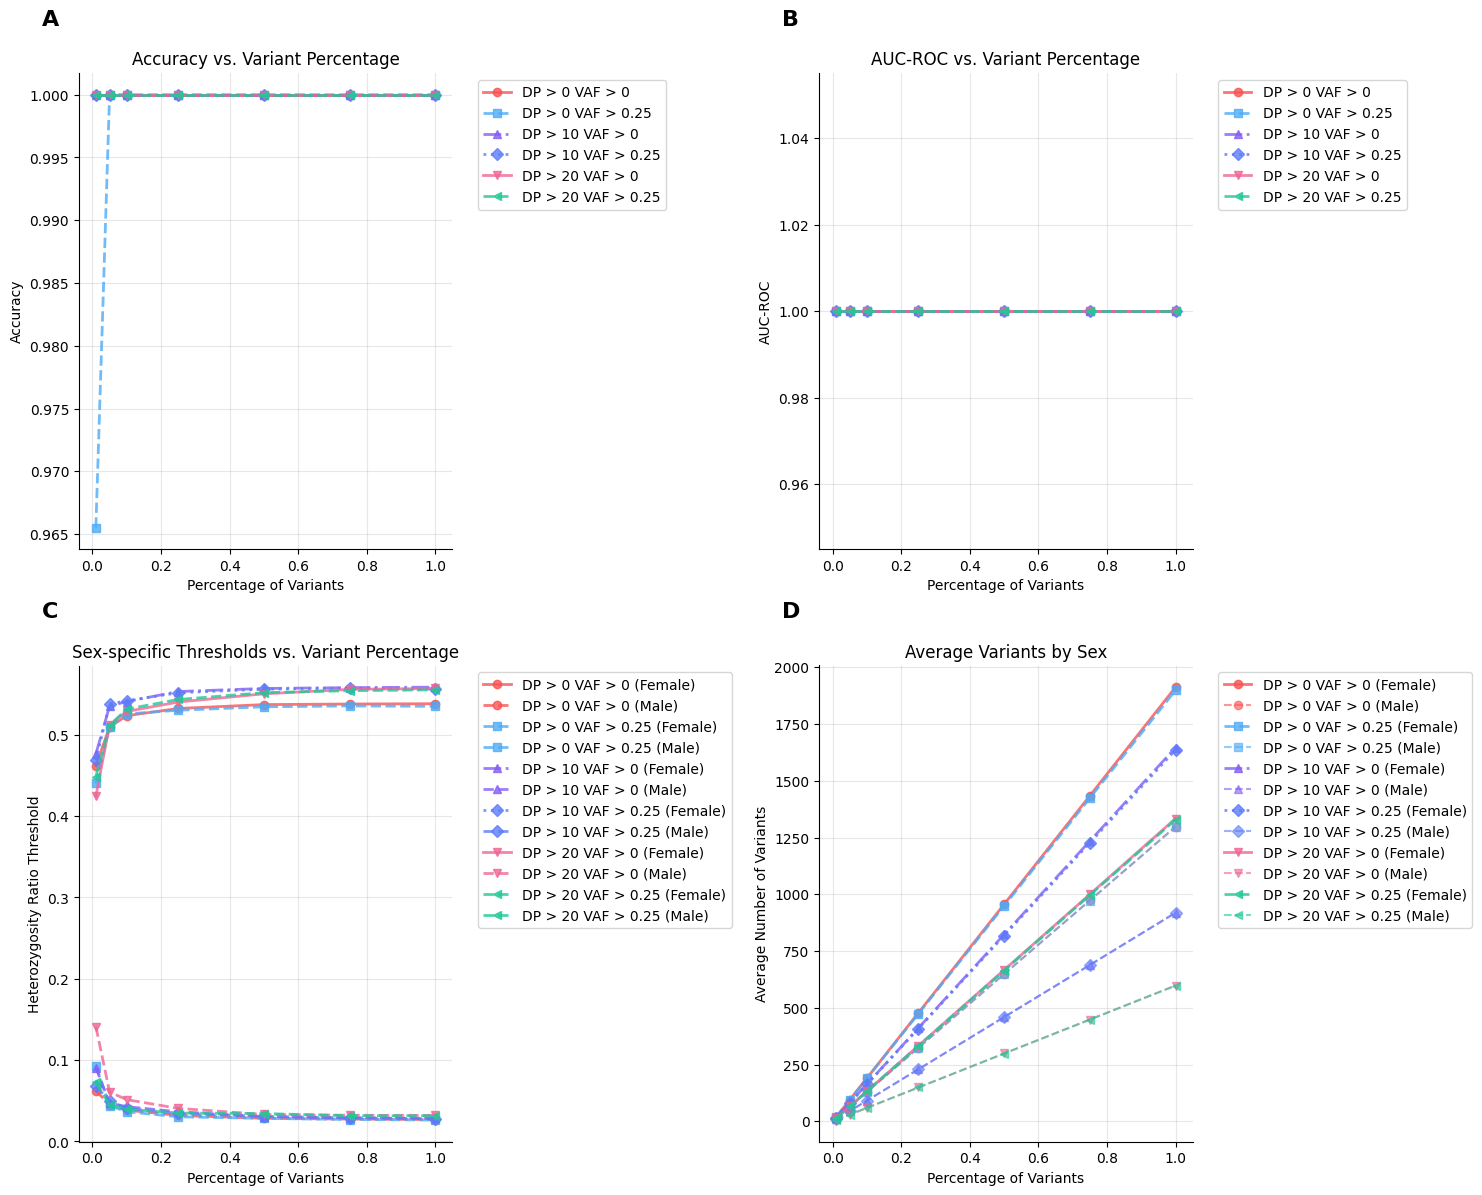

In [ ]:
def plot_results_comparison(results):
    """Create comparison plots matching the original aesthetic."""
    # Set font to DejaVu Sans to match original
    plt.rcParams['font.family'] = 'DejaVu Sans'

    # Define color palette matching the original
    colors = {
        'red': '#FA5252',      # red5
        'blue': '#4DABF7',     # blue5
        'violet': '#845EF7',   # violet5
        'indigo': '#5C7CFA',   # indigo5
        'pink': '#F06595',     # pink5
        'teal': '#20C997',     # teal5
    }

    # Define line styles and markers
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '<']

    # Organize results by DP/VAF conditions and percentages
    organized_results = {}
    percentages = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 1.0]

    for condition_name, result in results.items():
        # Parse condition name (e.g., "DP>0_VAF>0_50pct")
        parts = condition_name.split('_')
        dp_vaf = f"{parts[0]}_{parts[1]}"  # e.g., "DP>0_VAF>0"
        pct = float(parts[2].replace('pct', '')) / 100  # e.g., 0.50

        if dp_vaf not in organized_results:
            organized_results[dp_vaf] = {}
        organized_results[dp_vaf][pct] = result

    # Create subplots matching original layout
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot A: Accuracy vs. Variant Percentage
    ax1 = axes[0, 0]
    for i, (dp_vaf, metrics) in enumerate(organized_results.items()):
        pcts = sorted(metrics.keys())
        accuracies = [metrics[pct]['classification_results']['accuracy'] for pct in pcts]

        color = list(colors.values())[i % len(colors)]
        style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]

        ax1.plot(pcts, accuracies, 
                marker=marker, 
                linestyle=style, 
                color=color, 
                alpha=0.8,
                linewidth=2,
                label=dp_vaf.replace('>', ' > ').replace('_', ' '))

    ax1.set_xlabel('Percentage of Variants')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy vs. Variant Percentage')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold')

    # Plot B: AUC-ROC vs. Variant Percentage
    ax2 = axes[0, 1]
    for i, (dp_vaf, metrics) in enumerate(organized_results.items()):
        pcts = sorted(metrics.keys())
        aucs = [metrics[pct]['classification_results']['auc'] for pct in pcts]

        color = list(colors.values())[i % len(colors)]
        style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]

        ax2.plot(pcts, aucs, 
                marker=marker, 
                linestyle=style, 
                color=color, 
                alpha=0.8,
                linewidth=2,
                label=dp_vaf.replace('>', ' > ').replace('_', ' '))

    ax2.set_xlabel('Percentage of Variants')
    ax2.set_ylabel('AUC-ROC')
    ax2.set_title('AUC-ROC vs. Variant Percentage')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold')

    # Plot C: Sex-specific Thresholds vs. Variant Percentage
    ax3 = axes[1, 0]
    for i, (dp_vaf, metrics) in enumerate(organized_results.items()):
        pcts = sorted(metrics.keys())
        female_thresholds = [metrics[pct]['classification_results']['female_threshold'] for pct in pcts]
        male_thresholds = [metrics[pct]['classification_results']['male_threshold'] for pct in pcts]
        midpoint_thresholds = [metrics[pct]['classification_results']['midpoint_threshold'] for pct in pcts]

        style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        color = list(colors.values())[i % len(colors)]

        # Plot female thresholds
        ax3.plot(pcts, female_thresholds, 
                marker=marker, 
                linestyle=style, 
                color=color, 
                alpha=0.8,
                linewidth=2,
                label=f'{dp_vaf.replace(">", " > ").replace("_", " ")} (Female)')

        # Plot male thresholds
        ax3.plot(pcts, male_thresholds, 
                marker=marker, 
                linestyle='--', 
                color=color, 
                alpha=0.8,
                linewidth=2,
                label=f'{dp_vaf.replace(">", " > ").replace("_", " ")} (Male)')

        # # Plot midpoint thresholds
        # ax3.plot(pcts, midpoint_thresholds,
        #         marker=marker, 
        #         linestyle='-', 
        #         color=color, 
        #         alpha=0.8,
        #         linewidth=2,
        #         label=f'{dp_vaf.replace(">", " > ").replace("_", " ")} (Midpoint)')

    ax3.set_xlabel('Percentage of Variants')
    ax3.set_ylabel('Heterozygosity Ratio Threshold')
    ax3.set_title('Sex-specific Thresholds vs. Variant Percentage')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=16, fontweight='bold')

    # Plot D: Average Variants by Sex
    ax4 = axes[1, 1]
    for i, (dp_vaf, metrics) in enumerate(organized_results.items()):
        pcts = sorted(metrics.keys())

        # Calculate average variants for females and males
        female_variants = []
        male_variants = []

        for pct in pcts:
            df = metrics[pct]['het_ratios_df']
            female_avg = df[df['Sex'] == 'female']['Total_Variants'].mean()
            male_avg = df[df['Sex'] == 'male']['Total_Variants'].mean()
            female_variants.append(female_avg)
            male_variants.append(male_avg)

        color = list(colors.values())[i % len(colors)]
        style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]

        # Plot female variants (solid line)
        ax4.plot(pcts, female_variants, 
                marker=marker, 
                linestyle=style, 
                color=color, 
                alpha=0.8,
                linewidth=2,
                label=f'{dp_vaf.replace(">", " > ").replace("_", " ")} (Female)')

        # Plot male variants (dashed line)
        ax4.plot(pcts, male_variants, 
                marker=marker, 
                linestyle='--', 
                color=color, 
                alpha=0.6,
                linewidth=1.5,
                label=f'{dp_vaf.replace(">", " > ").replace("_", " ")} (Male)')

    ax4.set_xlabel('Percentage of Variants')
    ax4.set_ylabel('Average Number of Variants')
    ax4.set_title('Average Variants by Sex')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return fig

# Create comparison plots
plot_results_comparison(results)
